In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import operator

# Fault Condition 2 is for verifying the mixing air temperature is reading legitimate values. The theory is when blending air streams together or "mixing" the air streams the sensor value should be within some range defined by mechanical engineering theory. The analogy would be what would be the possible theoretical ranges of temperatures when blending a hot cup of coffee with a cup of ice water? Well, that statement depends on how much cold ice water and is blended with how much hot coffee, but the resulting mixing temperature would never ever be outside the range of the coffee or ice water but somewhere in between... Seems obvious, right? For HVAC mixing return air with some % of outside air at some given temperature the results should be pretty obvious.

* To note the AHU mixing air sensor can be a "controlling" type sensor for the PID controller for the economizer logic. Notorious to the industry is poorly installed mixing air temperature sensors where through the PID logic the AHU will gulp in too much outside air during cold weather conditions and the entire AHU will shut down on a freeze protection fault. One other thing to note is typically mixing air temperature sensors are "averaging" type temperatures (it’s like a ~20' spool) that needs to be unwound and install carefully to get a good "average" reading of blending air streams together in the mixing chamber of the AHU. The return and discharge air sensors are typically small probe type sensors installed into the AHU duct work.

* A word of caution is the overall accuracy of this test maybe all over the map when the outside, return, and mixing temperature are all closely similar like during mild outdoor conditions which could be economizing free cooling type weather. Best results would be like design day conditions like extreme winter outdoor or extreme heat in summer.

Schematic below is from this blog about HVAC: https://www.hvacbrain.com/blog/vav-versus-vvt/

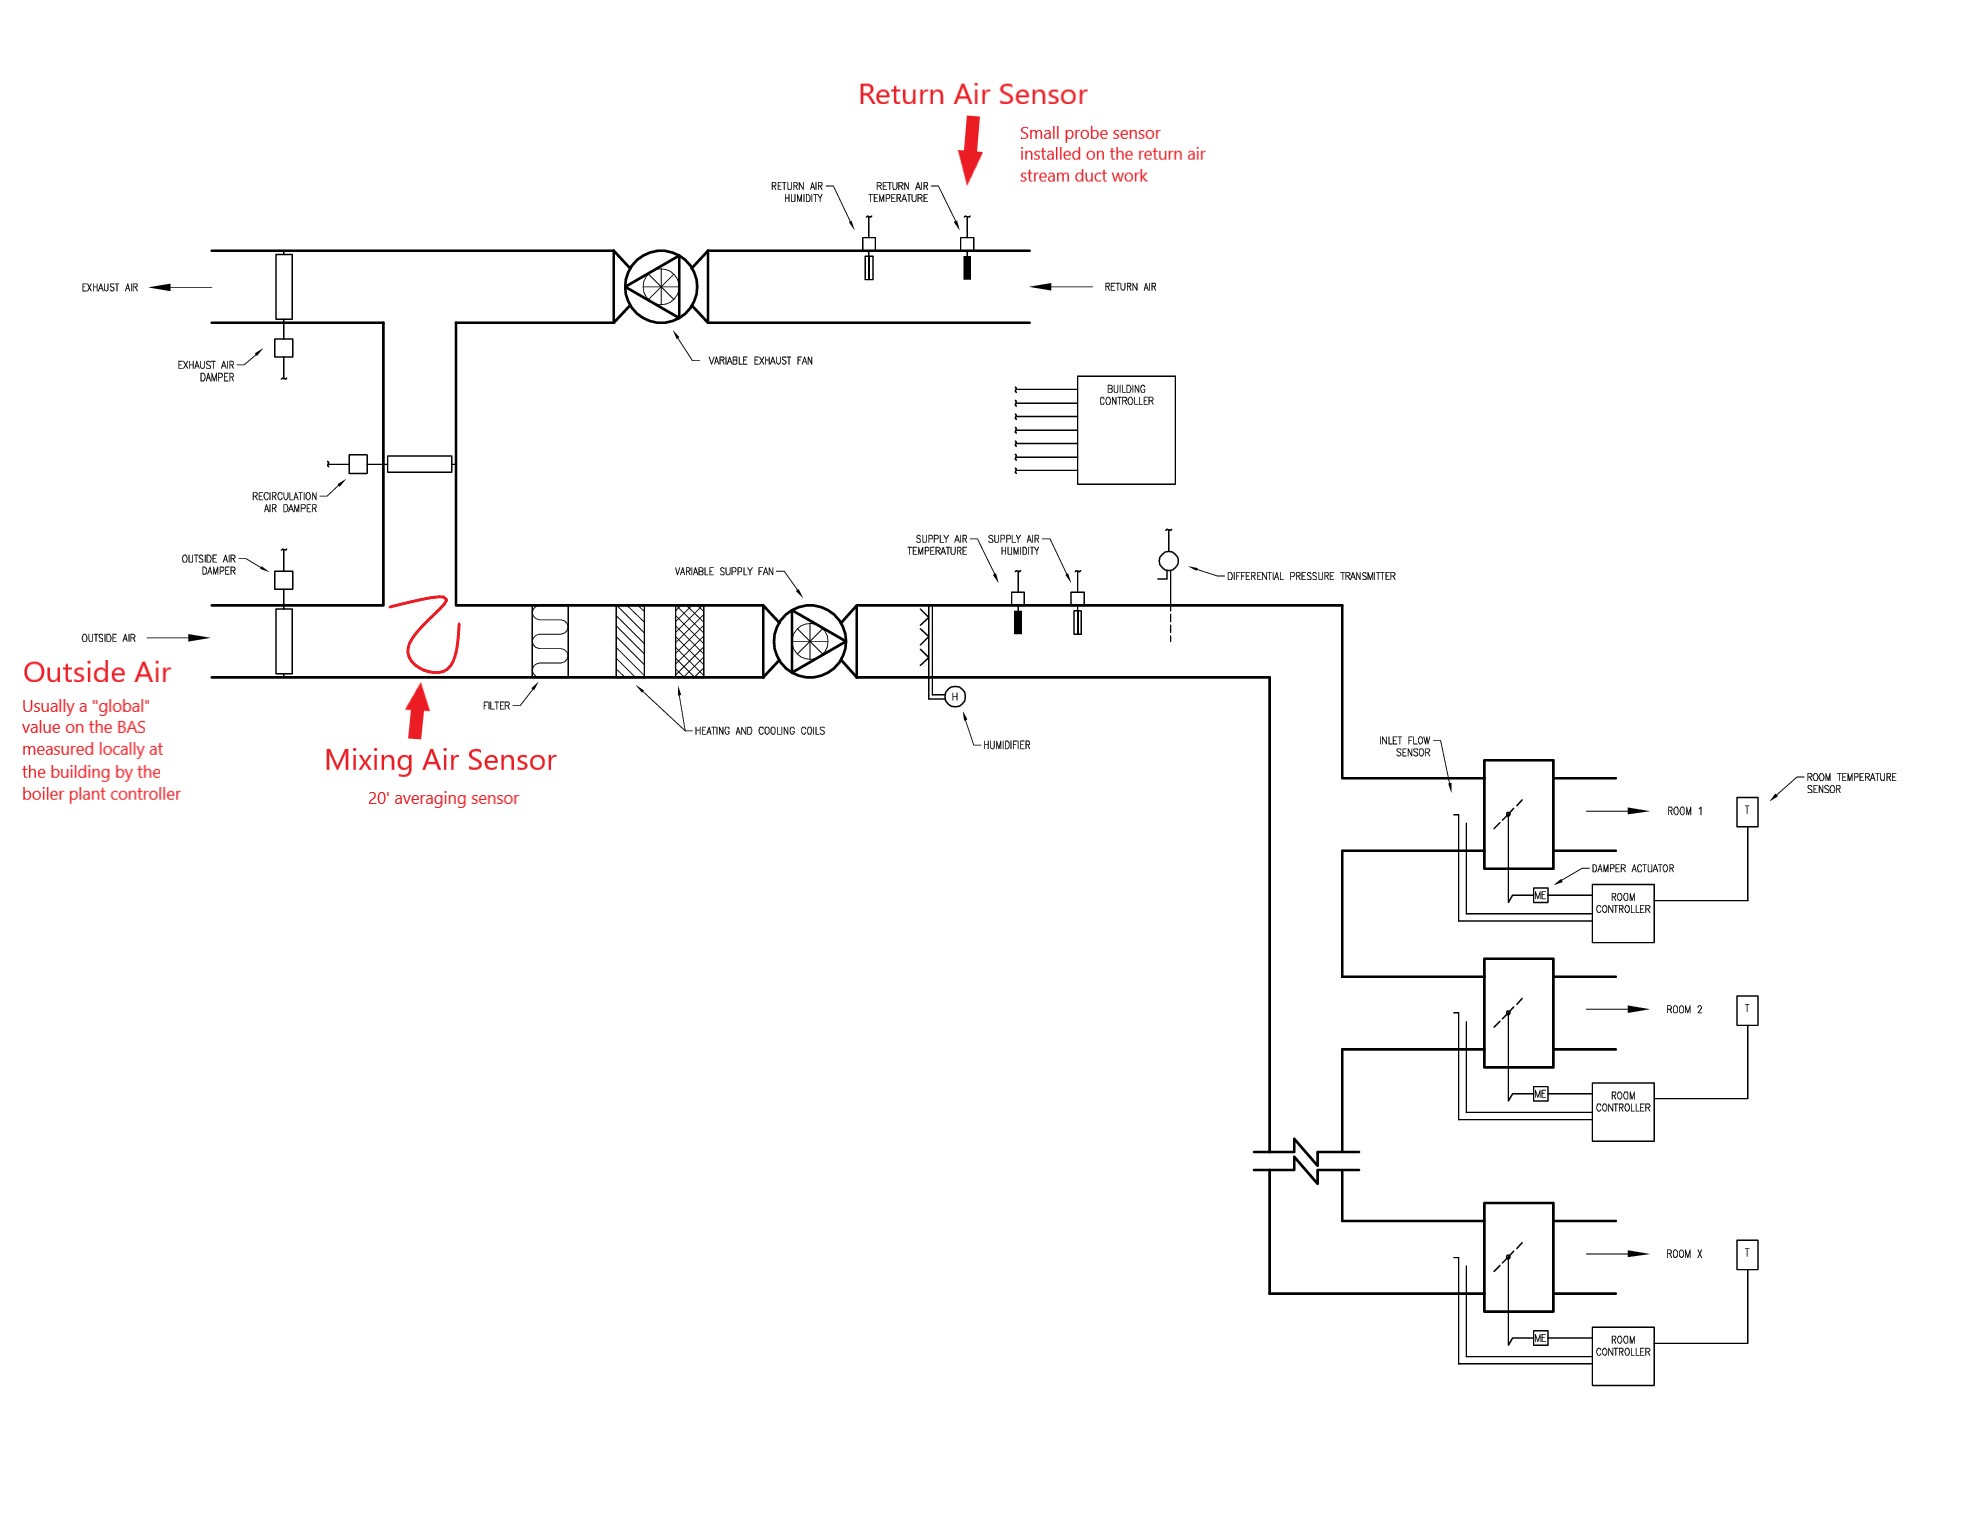

# This measure applies to all "MODES" for AHU. I.E., heating, cooling, economizer, etc. Defined as a OS#

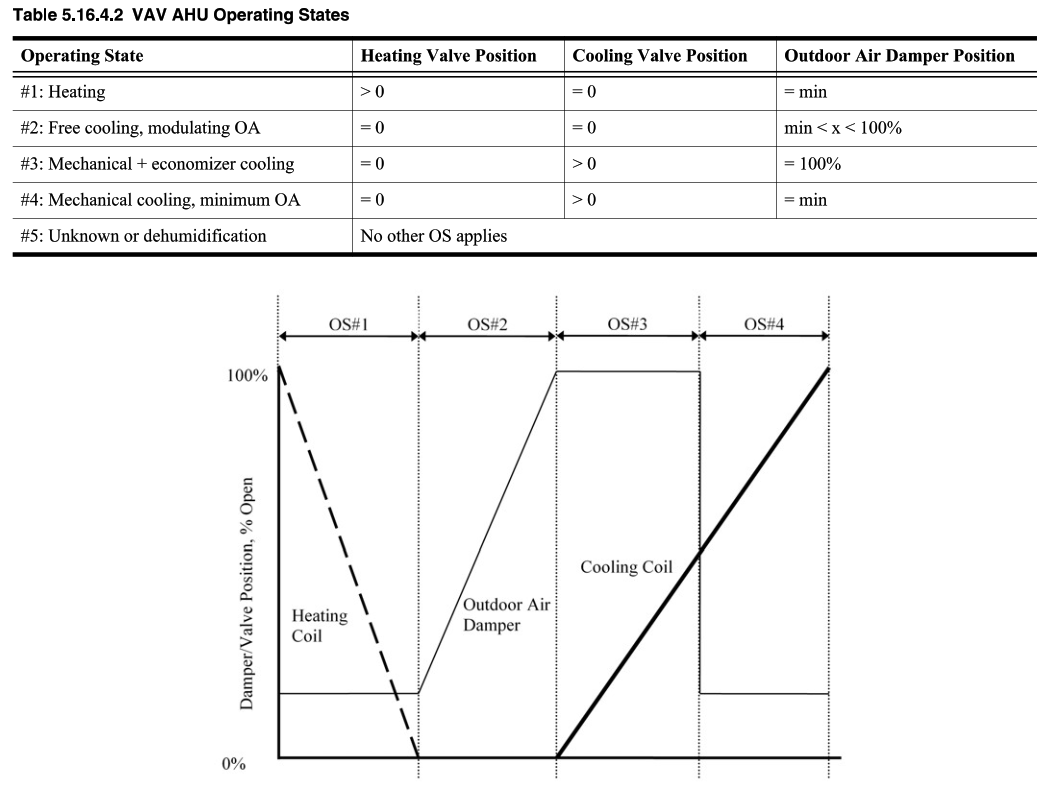

# Snip of ASHRAE Fault Condition 1 definition related to AHU Fan Speed and Duct Pressure Control

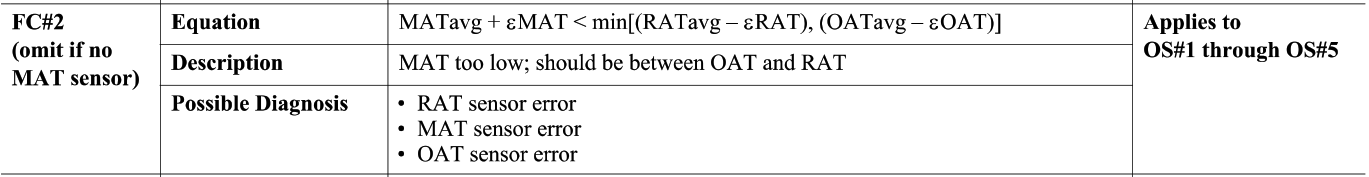

In [2]:
# returns entire dataframe with flag

def fault_condition_two(dataframe):

    for index, row in dataframe.iterrows():
        rtu_temps_avg['fc2_flag'] =  row['mat'] + row['mix_degf_err_thres'] < min((row['rat'] - row['return_degf_err_thres']), (row['oat'] - row['outdoor_degf_err_thres']))

    return dataframe




# Read Associated CSV files forward fill dataset and remove NaNs

In [3]:
rtu_temps = pd.read_csv('./summer_data/RTU Temperatures-data-as-seriestocolumns-2021-11-05 12_04_38.csv', index_col='Time', parse_dates=True).fillna(method='ffill').dropna()

# Compute 5 Min Rolling Avg Per G36 Spec

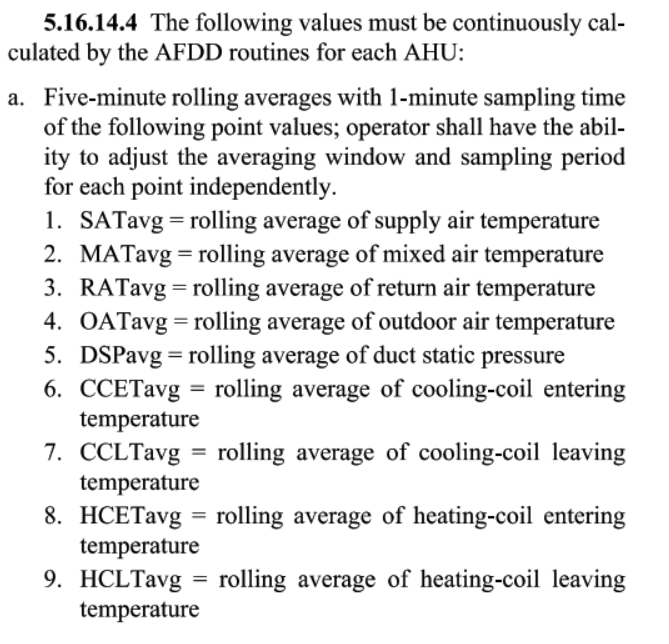

In [4]:
rtu_temps_avg = rtu_temps.rolling('5T').mean()

rtu_temps_avg.head()

,slipstream_internal/slipstream_hq/1100/Discharge Air Temperature,slipstream_internal/slipstream_hq/1100/Mixed Air Temperature Local,slipstream_internal/slipstream_hq/1100/Return Air Temperature,slipstream_internal/slipstream_hq/1100/Discharge Air Cooling Setpoint BAS,slipstream_internal/slipstream_hq/1002/Outside Air Temperature local
Time,,,,,
2021-08-09 00:00:00,78.4,76.70,76.4,55.0,70.5
2021-08-09 00:01:00,78.4,76.70,76.4,55.0,70.5
2021-08-09 00:01:00,78.4,76.70,76.4,55.0,70.5
2021-08-09 00:02:00,78.4,76.70,76.4,55.0,70.5
2021-08-09 00:02:00,78.4,76.68,76.4,55.0,70.5


In [5]:
rtu_temps_avg.columns

Index(['slipstream_internal/slipstream_hq/1100/Discharge Air Temperature',
       'slipstream_internal/slipstream_hq/1100/Mixed Air Temperature Local',
       'slipstream_internal/slipstream_hq/1100/Return Air Temperature',
       'slipstream_internal/slipstream_hq/1100/Discharge Air Cooling Setpoint BAS',
       'slipstream_internal/slipstream_hq/1002/Outside Air Temperature local'],
      dtype='object')

In [6]:
# rename columns
rtu_temps_avg.rename(columns={'slipstream_internal/slipstream_hq/1100/Discharge Air Temperature': 'dat', # discharge air temp not needed
                   'slipstream_internal/slipstream_hq/1100/Mixed Air Temperature Local': 'mat',
                   'slipstream_internal/slipstream_hq/1100/Return Air Temperature': 'rat',
                   'slipstream_internal/slipstream_hq/1100/Discharge Air Cooling Setpoint BAS': 'dat_sp', # discharge air sp temp not needed
                   'slipstream_internal/slipstream_hq/1002/Outside Air Temperature local': 'oat'}, inplace=True)

In [7]:
rtu_temps_avg = rtu_temps_avg[['mat', 'rat', 'oat']]

In [8]:
rtu_temps_avg.columns

Index(['mat', 'rat', 'oat'], dtype='object')

In [9]:
# small dataset logged from VOLTTRON on 1 min intervals.
# Its about 3 days of data which was the max my
# web browser could handle retrieving the data
# via grafana interface

rtu_temps_avg.describe()

,mat,rat,oat
count,14390.000000,14390.000000,14390.000000
mean,75.287426,73.929098,76.274771
std,4.264325,2.697062,8.814327
min,67.922222,68.400000,62.777778
25%,71.766667,72.440000,68.880000
50%,74.933333,73.557778,72.627778
75%,79.028056,75.200000,84.360000
max,83.888889,82.444444,97.988889


# Plot data for visulation 

array([<AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>], dtype=object)

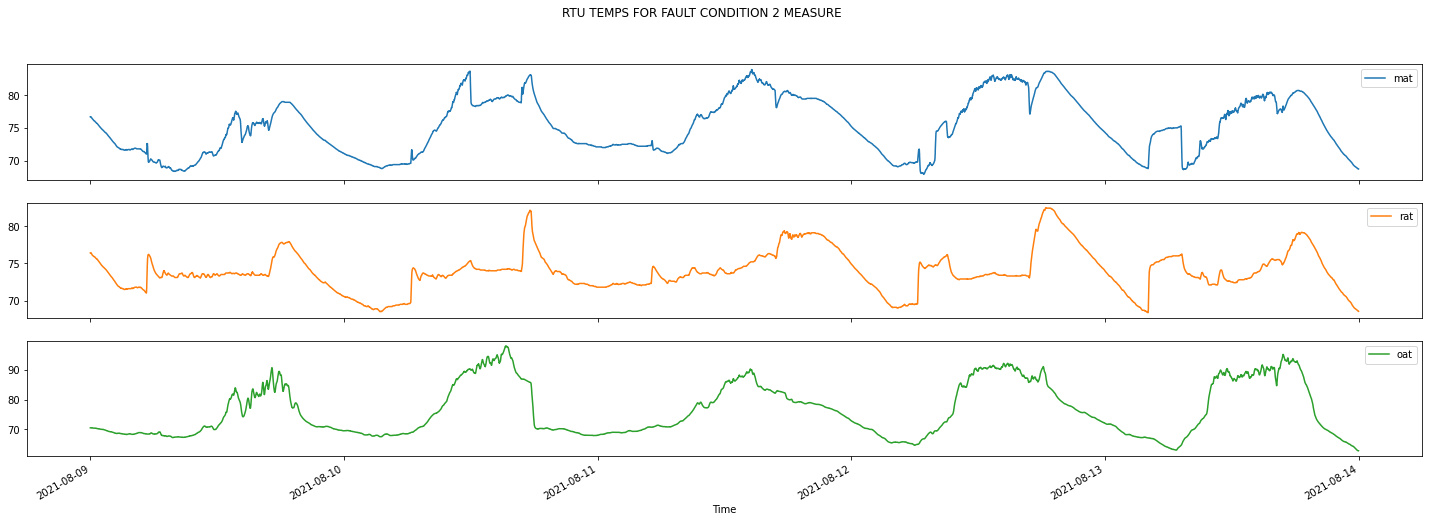

In [10]:
rtu_temps_avg.plot(figsize=(25,8), subplots=True, title='RTU TEMPS FOR FAULT CONDITION 2 MEASURE')

* Note hot weather in summer data above. oat = Outdoor Temp, rat = Return Air Temp, mat = Mix Air Temp

# Set Internal Variables per G36 Spec Imperial Units

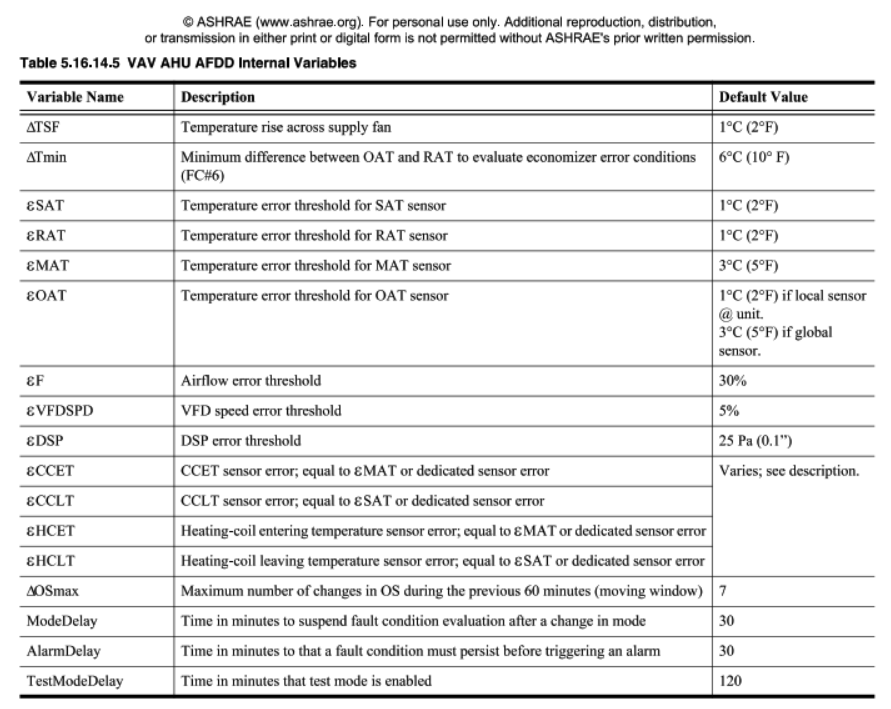

In [11]:
supply_fan_delta_degf = 2.
oat_rat_delta_degf_min = 10.
supply_degf_err_thres = 2.
return_degf_err_thres = 2.
mix_degf_err_thres = 5.
outdoor_degf_err_thres = 5.
air_flow_percent_thres = .3
vfd_speed_percent_err_thres = .05
vfd_speed_percent_max = .99
duct_static_inches_err_thres = .1
delta_os_max = 7.
mode_delay = 30.
alarm_dely = 30.
test_mode_delay = 120.

In [12]:
# make an entire column out of these params in the Pandas Dataframe
rtu_temps_avg['outdoor_degf_err_thres'] = outdoor_degf_err_thres
rtu_temps_avg['mix_degf_err_thres'] = mix_degf_err_thres
rtu_temps_avg['return_degf_err_thres'] = return_degf_err_thres

In [13]:
rtu_temps_avg.columns

Index(['mat', 'rat', 'oat', 'outdoor_degf_err_thres', 'mix_degf_err_thres',
       'return_degf_err_thres'],
      dtype='object')

# Run dataset through the function we created in cell 2 that will attempt to FLAG some faults!

In [14]:
rtu_temps_avg = fault_condition_two(rtu_temps_avg)

In [16]:
rtu_temps_avg['fc2_flag'].value_counts()

False    14390
Name: fc2_flag, dtype: int64

In [19]:
rtu_temps_avg.columns

Index(['mat', 'rat', 'oat', 'outdoor_degf_err_thres', 'mix_degf_err_thres',
       'return_degf_err_thres', 'fc2_flag'],
      dtype='object')

In [21]:
# change boolean column to int for plots

rtu_temps_avg['fc2_flag'] = rtu_temps_avg['fc2_flag'].astype(int)

# drop params column for better plot
rtu_temps_avg = rtu_temps_avg.drop(['outdoor_degf_err_thres',
                  'mix_degf_err_thres',
                  'return_degf_err_thres'],axis=1)


<AxesSubplot:title={'center':'FC 1 Test'}, xlabel='Time'>

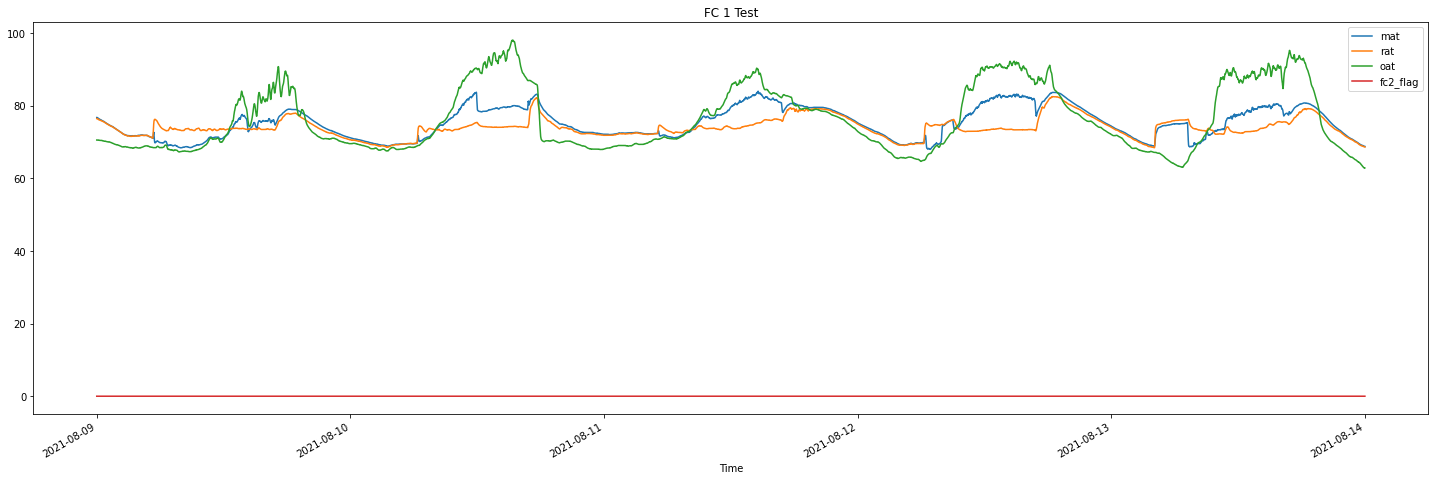

In [22]:
# seems like its working : )

fdd_plot = rtu_temps_avg

fdd_plot.plot(figsize=(25,8),title='FC 1 Test')

In [ ]:
# Lets ZOOM in on a day with all data!

zoom_plot = fc1_dataset.loc['2021-8-9'].between_time('5:00', '17:00')
_no_vfd_sig = zoom_plot[['fc1_flag','duct_static','duct_static_setpoint']]
_vfdsig = zoom_plot.vfd_speed


# using subplots() function
fig, ax = plt.subplots(figsize=(25,8))
plt.title('Visually verify FDD is flagging OK')
 
# using the twinx() for creating another
# axes object for secondary y-Axis
ax2 = ax.twinx()
ax.plot(zoom_plot.index, _no_vfd_sig)
ax2.plot(zoom_plot.index, _vfdsig, color = 'r')


handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles1+handles2
labels = labels1+labels2
fig.legend(handles, labels, loc='upper center')

# giving labels to the axises
ax.set_xlabel('Date')
ax.set_ylabel('Duct Pressure and FDD Flag')

# secondary y-axis label
ax2.set_ylabel('RED LINE - % Fan Speed')


 
# show plot
plt.show()

# The Fault Flag seems like its working!

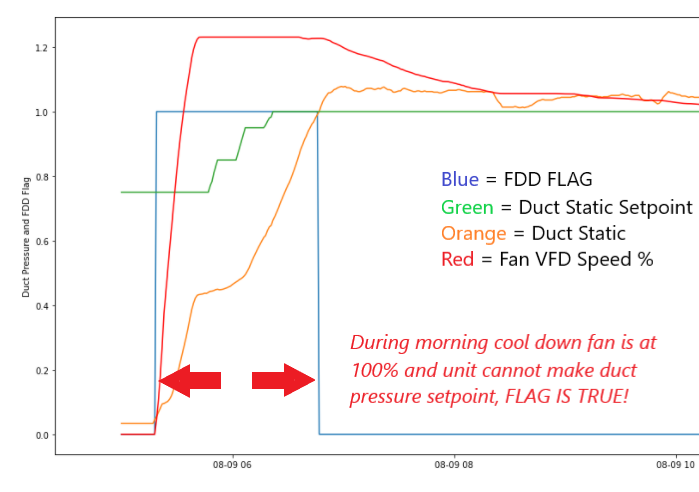

# The second D in FDD is "Diagnostics"

Let's get creative : )

* Calculate percent TRUE AND FALSE of FDD Flag

In [ ]:
percent_true = fdd_plot.fc1_flag.mean()

print("Percent of time in the dataset when FLAG is True")

percent_true

In [ ]:
percent_false = 1 - percent_true

print("Percent of time in the dataset when FLAG is False")

percent_false

* Calculate elapsed time for fault conditions True

In [ ]:
# https://stackoverflow.com/questions/49277932/difference-pandas-datetimeindex-without-a-frequency#:~:text=there%20is%20no%20implemented%20diff%20function%20yet%20for%20index.

In [ ]:
fc1_dataset_copy = fc1_dataset.copy()


#filter dataset for when "FLAG" is True
fc1_dataset_copy = fc1_dataset_copy[fc1_dataset_copy.fc1_flag == 1]


In [ ]:
fc1_dataset_copy.fc1_flag.sum()

In [ ]:
fc1_dataset_copy['time_td'] = fc1_dataset_copy.index.to_series().diff().astype('timedelta64[m]')

In [ ]:
print("TIME IN MINUTES the FLAG is TRUE")

fc1_dataset_copy.time_td.sum()

In [ ]:
print("TIME IN HOURS the FLAG is TRUE")

fc1_dataset_copy.time_td.sum() / 60

* Plot on histogram the hour of the day the "FLAG" is TRUE

In [ ]:
fc1_dataset_copy['hour_of_the_day'] = fc1_dataset_copy.index.hour

fc1_dataset_copy.hour_of_the_day.plot.hist(title='Hour Of Day When Flag is TRUE',figsize=(25,8))

In [ ]:
print("Duct Pressure Average for dataset when FLAG IS TRUE")

fc1_dataset_copy.duct_static.mean()

# What else would be interesting to see in FDD Diagnostics? Post a comment or send me an email!